# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 1 - Image Classification
---

### <a style='color:red'> Due Date: 23.11.2022 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* **DON'T** submit the CIFAR-10 dataset in your submission, we have a local copy of it.
* **DON'T** submit the trained networks, but make sure to document every result you get.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Classifier
---
In this part we are going to examine the performance of a classical classifier over images from the **Canadian Institute For Advanced Research (CIFAR-10)**  Dataset. 

* The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
  * There is also CIFAR-100, with 100 classes.
* The classes are completely mutually exclusive. For example, there is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.
* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Official Site</a>


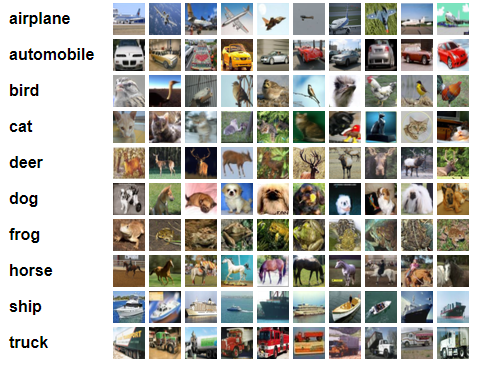


1. Load the CIFAR-10 training and test set with PyTorch (<a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10">read more here</a>). Display 5 images from the training set with their labels as title.

2. Build a K-Nearest Neighbors (K-NN) classifier (hint: `sklearn.neighbors.KNeighborsClassifier`), with `n_neighbors=10`, to classify CIFAR-10: Load 10,000 samples from the training set and train the model. 

  **Note**: The model's input dimension should be : `(n_samples, n_features)`, Thus you need to convert each color channel to row representation and then concatenate the 3 color channels.

3. Load 1,000 samples from CIFAR-10 test set and check the performance of the K-NN classifier over these samples. What is the accuracy obtained? View the results using a confusion matrix

4. Compare the model's accuracy for different number of neighbors ($1 \leq K \leq 30$ ). Display the results in a graph of accuracy as function of $K$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import CIFAR10
from torchvision import transforms, models
import torch.nn as nn
import time
import os
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# check if there is a GPU available
print(torch.cuda.is_available())
# check what is the current available device
if torch.cuda.is_available():
    print("current device: ", torch.cuda.current_device())
# automatically choose device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use gpu 0 if it is available, o.w. use the cpu
print("device: ", device)

False
device:  cpu


In [3]:
data_dir = 'cifar-10-batches-py' 

transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root=data_dir, train=True, transform=transform_train, download=True)

test_dataset = CIFAR10(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


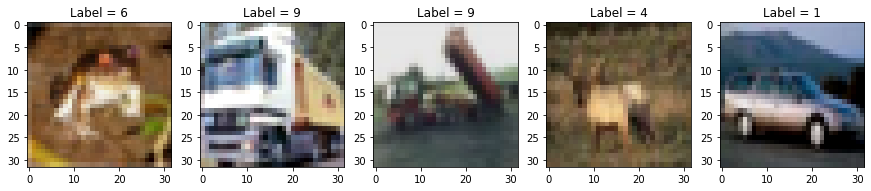

In [4]:
fig = plt.figure(figsize=(15, 15))

for i in range(5):
    ax = fig.add_subplot(1, 5 ,i + 1)
    ax.imshow(train_dataset[i][0].permute(1, 2, 0))
    #cmap='gray'
    ax.set_title('Label = '+ f'{train_dataset[i][1]}')

In [5]:
model_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=10000, 
                                           shuffle=True, drop_last=True)

model_test_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1000, 
                                           shuffle=False)

examples_train = enumerate(model_train_loader)
batch_train_idx, (example_data_train, example_targets_train) = next(examples_train)
example_data_train = example_data_train.flatten(start_dim=1)

examples_test = enumerate(model_test_loader)
batch_test_idx, (example_data_test, example_targets_test) = next(examples_test)
example_data_test = example_data_test.flatten(start_dim=1)


KNN_model = KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(example_data_train, example_targets_train)
pred = KNN_model.predict(example_data_test)

model accuracy is: 30.700% 


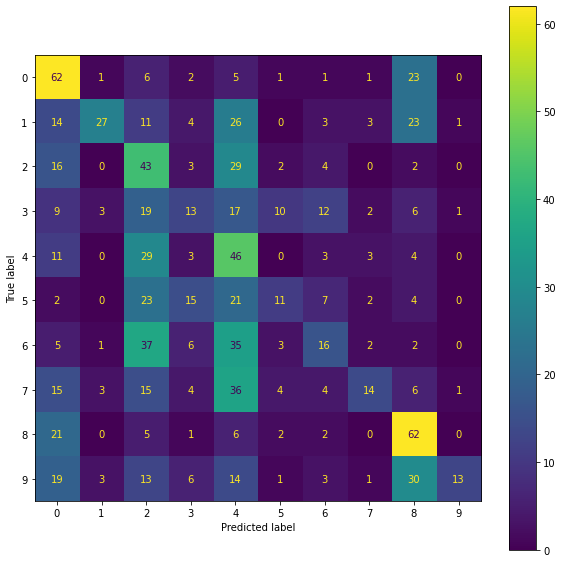

In [6]:
model_score = KNN_model.score(example_data_test,example_targets_test)
print('model accuracy is: {:.3f}% '.format(model_score*100))
disp_con_mat = ConfusionMatrixDisplay(confusion_matrix(example_targets_test,pred))

fig, ax = plt.subplots(figsize=(10,10))
disp_con_mat.plot(ax=ax)
plt.show()

In [7]:
accuracy_results = []

for i in range(1,31):
    KNN_model = KNeighborsClassifier(n_neighbors=i)
    KNN_model.fit(example_data_train, example_targets_train)
    pred = KNN_model.predict(example_data_test)
    model_score = KNN_model.score(example_data_test,example_targets_test)
    accuracy_results.append(model_score)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,5))
plt.title('KNN Classifier Accuracy')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')

plt.plot(np.arange(1,31),accuracy_results)
plt.grid()
plt.show()

#### Part 2 - Design and Build a CNN Classifier
---
In this part you are going to design a deep convolutional neural network to classify CIFAR-10 dataset. 

1. Use the CNN from tutorials 3-4 (`SvhnCnn()`) and train it on the CIFAR-10 dataset (**keep the architecture the same**) for the same number of **epochs** with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?
    * Your test accuracy from this section will be your **baseline** accuracy for sections 2-3.

2. Design your own Convolutional Neural Network (CNN) to classify CIFAR-10. You can modify the network from section 1,but **you must get a better result than your baseline accuracy from section 1**.
    * You **need** to use one of the following in your CNN - Residual block, activation function PReLU, activation function Leaky ReLU, Group Normalization, Exponential moving average (EMA).
      Explain the technique you have chosen.
    * Describe the chosen architecture, how many layers? What activations did you choose? What are the filter sizes? Did you use fully-connected layers (if you did, explain their sizes)?
    * What is the input dimension? What is the output dimension?
    * Calculate the number of parameters (weights) in the network.

  **Note:** 
    * The new network should perform better over the same task (i.e. using the same data with the same hyper-parameters. Change only the network architecture).
    * Students who reach the highest accuracy over the test set will receive **5 bonus points** for this exercise.


3. Train the classifier (preferably on a **GPU - use Colab for this part** if you don't have a GPU).
    * Describe the hyper-parameters of the model (batch size, epochs, learning rate....). How did you tune your model? Did you use a validation set to tune the model? (<a href="https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123">Separating to train/validation/test in PyTorch</a>)
    * What is the final accuracy on the test set?

In [ ]:
class SvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(SvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            # What are the dims after this layer? 
            # How many weights?
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),  # <- Why is this here?

            # Modified Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # As we go deeper - use more channels!
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 512),  # <- How do we know it's 8192? Why 512 later?
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)  # <- Why 10 here?
        )

    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [ ]:
# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    
    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/svhn_cnn_ckpt.pth')

print('==> Finished Training ...')
test_accuracy, _ = calculate_accuracy(model, testloader, device)
print("Accuracy: {:.3f}% ".format(test_accuracy))

In [ ]:
class BariaCNN(nn.Module):

    def __init__(self):
        super(BariaCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.005,inplace=True),
            
            nn.Conv2d(in_channels=60, out_channels=90, kernel_size=3, padding=1),
            nn.BatchNorm2d(90),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.07),  

            nn.Conv2d(in_channels=90, out_channels=180, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=180, out_channels=270, kernel_size=3, padding=1),
            nn.BatchNorm2d(270),
            nn.ReLU(inplace=True),
            

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1080, 40),
            nn.ReLU(inplace=True),
            nn.Linear(40, 20) ,
            nn.ReLU(inplace=True),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
batch_size = 128
learning_rate = 1e-4
epochs = 5
K = 10

criterion = nn.CrossEntropyLoss()
kf = KFold(n_splits=K, shuffle=True)

our_model = BariaCNN().to(device)

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(our_model.parameters(), lr=learning_rate)

In [ ]:
# training loop

for fold, (train_ids, test_ids) in enumerate(kf.split(train_dataset)):
    print('--------------------------------')
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and val data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=batch_size, sampler=val_subsampler)
    
    for epoch in range(1, epochs + 1):
        our_model.train()  # put in training mode
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # send them to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = our_model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # calculate the loss
            # always the same 3 steps
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = calculate_accuracy(our_model, trainloader, device)
        val_accuracy, _ = calculate_accuracy(our_model, valloader, device)

        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, val_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)
        
        # save model
        if epoch % 20 == 0:
            print('==> Saving model ...')
            state = {
                'net': our_model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, './checkpoints/baria_cnn_ckpt.pth')

print('==> Finished Training ...')
test_accuracy, _ = calculate_accuracy(our_model, testloader, device)
print("Accuracy: {:.3f}% ".format(test_accuracy))

#### Part 3 - Analyzing a Pre-trained CNN
---
In this part you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>

1. Load a pre-trained VGG16 with PyTorch using `torchvision.models.vgg16(pretrained=True, progress=True, **kwargs)` (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (`model.eval()`). 

In [8]:
vgg16_nn = models.vgg16(pretrained=True, progress=True)
vgg16_nn.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. Load the images in the `./data/birds` folder and display them.

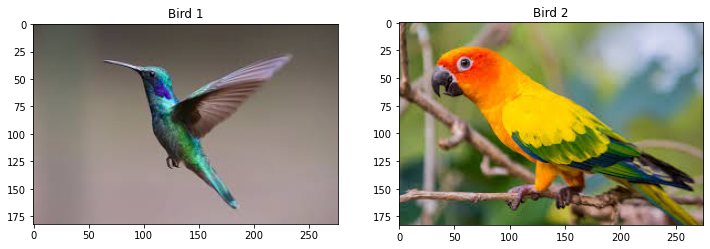

In [9]:
path = './data/birds'

img_bird1 = cv2.imread('./data/birds/bird_0.jpg')
img_bird1 = cv2.cvtColor(img_bird1, cv2.COLOR_BGR2RGB)

img_bird2 = cv2.imread('./data/birds/bird_1.jpg')
img_bird2 = cv2.cvtColor(img_bird2, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 2 ,1)
ax.imshow(img_bird1)
ax.set_title('Bird 1')

ax = fig.add_subplot(1, 2 ,2)
ax.imshow(img_bird2)
ax.set_title('Bird 2')

plt.show()

3. Pre-process the images to fit VGG16's architecture. What steps did you take?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


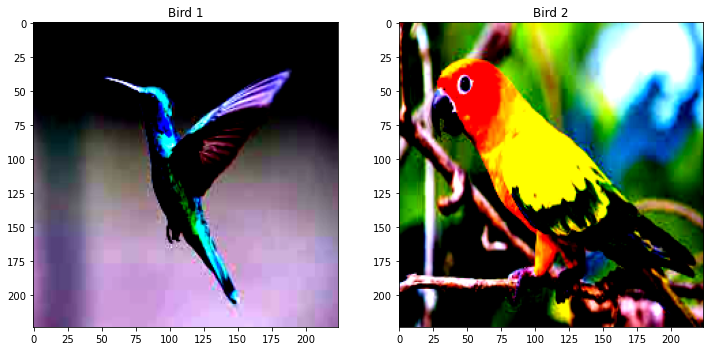

In [10]:
transform_img = transforms.Compose([
    transforms.ToTensor(), # converts all images into [0,1]
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_img1 = transform_img(img_bird1)
tensor_img2 = transform_img(img_bird2)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 2 ,1)
ax.imshow(tensor_img1.permute(1, 2, 0))
ax.set_title('Bird 1')

ax = fig.add_subplot(1, 2 ,2)
ax.imshow(tensor_img2.permute(1, 2, 0))
ax.set_title('Bird 2')
plt.show()

In [11]:
# reading the data from the file
with open('./data/imagenet1000_clsidx_to_labels.txt') as f:
    data = f.read()
    labels = eval(data)

prediction = vgg16_nn(tensor_img1.unsqueeze(0))
class_id = prediction.argmax().item()
category_name = labels[class_id]
print('First bird: ', category_name)

prediction = vgg16_nn(tensor_img2.unsqueeze(0))
class_id = prediction.argmax().item()
category_name = labels[class_id]
print('Second bird: ', category_name)

First bird:  hummingbird
Second bird:  lorikeet


5. Find an image of a bird/cat/dog on the internet, display it and feed it to network. What are the outputs?

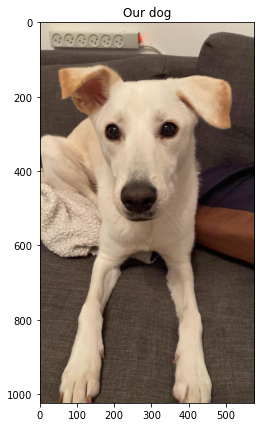

In [12]:
img_dog1 = cv2.imread('./data/my_data/dog1.jpg')
img_dog1 = cv2.cvtColor(img_dog1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7, 7))
plt.imshow(img_dog1)
plt.title('Our dog')
plt.show()

In [13]:
tensor_img3 = transform_img(img_dog1)
prediction = vgg16_nn(tensor_img3.unsqueeze(0))
class_id = prediction.argmax().item()
category_name = labels[class_id]
print('Our dog: ', category_name)

Our dog:  whippet


6. For the first 3 filters in the *first layer* of VGG16, plot the filters, and then plot their response (their output) for the image from section 5. Explain what do you see.
    * Consult `ee046746_appndx_visualizing_cnn_filters.ipynb` to refresh your memory.

In [26]:
# functions to visualize the kernels and outputs
def plot_filters_multi_channel(t):
    num_kernels = t.shape[0]    
    num_cols = 12
    num_rows = num_kernels
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    for i in range(3):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        npimg = np.array(t[i].numpy(), np.float32)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    
    
def plot_weights(model, layer_num):
    layer = model.features[layer_num]
    if isinstance(layer, nn.Conv2d):
        weight_tensor = model.features[layer_num].weight.data
        plot_filters_multi_channel(weight_tensor)
    else:
        print("Can only visualize layers which are convolutional")


def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(3):
        filters.append(output[i,:,:])
        
    fig = plt.figure(figsize=(8, 8))

    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_axis_off()
    plt.tight_layout()

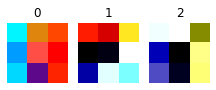

In [18]:
plot_weights(vgg16_nn, 0)

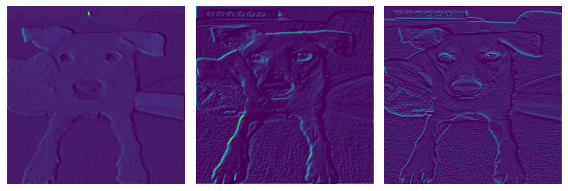

In [27]:
filter_outputs(tensor_img3.unsqueeze(0), vgg16_nn, 0)

7. For each image in the `./data/dogs` and `./data/cats`folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as `FC7`) of the VGG16 model. Which layer did you pick? What is the size of the feature space?
    * You need to write a function that does the feed forward manually until the desired layer. See the example in `ee046746_appndx_visualizing_cnn_filters.ipynb`. 

In [34]:
def list_dir(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def fc_layer_outputs(image, model):

    for i, features in enumerate(model.children()):
        if i == 2:
            image = image.reshape(1, -1)
        for layer in features[:-3]:
            image = layer(image)
        else:
            
            image = features(image)
        
      
    return image

In [38]:
dogs_path = './data/dogs'
cats_path = './data/cats'

dogs_list = list_dir(dogs_path)
cats_list = list_dir(cats_path)
all_list = dogs_list + cats_list

img_tensor_list = []
for img_path in all_list[1:]:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor_img = transform_img(img)
    print(tensor_img.shape)
    print(tensor_img.unsqueeze(0).shape)    
    img_tensor_list.append(fc_layer_outputs(tensor_img, vgg16_nn))

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 224, 224] instead

8. Build a Support Vector Machine (SVM) classifier (hint: `sklearn.svm.LinearSVC`) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the `scikit-learn` library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

In [ ]:
#load train
train_set = img_tensor_list

train_labels = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]

In [ ]:
#load test
test_set = []

test_dog1 = cv2.imread('./data/my_data/dog3.jpg')
test_dog1 = cv2.cvtColor(test_dog1, cv2.COLOR_BGR2RGB)
test_dog1 = transform_img(test_dog1)
test_set.append(fc_layer_outputs(test_dog1, vgg16_nn))

test_dog2 = cv2.imread('./data/my_data/dog4.jpg')
test_dog2 = cv2.cvtColor(test_dog2, cv2.COLOR_BGR2RGB)
test_dog2 = transform_img(test_dog2).squeeze(0)
test_set.append(fc_layer_outputs(test_dog2, vgg16_nn))

test_cat1 = cv2.imread('./data/my_data/cat1.jpg')
test_cat1 = cv2.cvtColor(test_cat1, cv2.COLOR_BGR2RGB)
test_cat1 = transform_img(test_cat1)
test_set.append(fc_layer_outputs(test_cat1, vgg16_nn))

test_cat2 = cv2.imread('./data/my_data/cat2.jpg')
test_cat2 = cv2.cvtColor(test_cat2, cv2.COLOR_BGR2RGB)
test_cat2 = transform_img(test_cat2)
test_set.append(fc_layer_outputs(test_cat2, vgg16_nn))

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
print(train_set)
clf.fit(train_set, train_labels)
print(clf.predict(test_set))

#### Part 4 - Dry Questions

---
1. A researcher is thinking to design a bag of words algorithm for flags detection.
Describe the pros and cons of the methods in this case. Below are some flag images you can use.


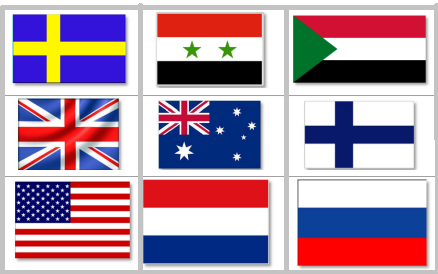



2. Danny is interested to design a dogs classifier. He has dataset of RGB images of 3 types of dogs in dimensions of 64X64 (i.e. the dimension of each image is 3X64X64). In the following table, the network architecture is defined in the leftmost column. You need to fill in the two additional columns: In the middle column fill the output dimensions and in the right column the number of learnd parameters (weights). The answer should be written as multiples (for example: 128 × 128 × 3 ).No need to consider bias. 

  **Conv7-N**: A convolution layer with N neurons, each one has dimensions of 7 × 7 × D where D is the volume depth activation in the previous layer. Padding = 2 and  Stride = 1.

  **POOL2**: 2 × 2  Max-Pooling activation with Stride=2. If the input to the layer is an odd number, round it down.

  **FC-N**: Fully Connected layer with N neurons. 

\begin{array}{|c|c|} \hline
\text{Layer} & \text{Output dimensions}  & \text{Number of parameters (weights)}  \\ \hline
INPUT & 64 × 64 × 3 & 0  \\ \hline
CONV7-16 &  &   \\\hline
POOL2 &  &   \\ \hline
CONV7-32 &  &   \\ \hline
POOL2 &  &   \\ \hline
FC-3 &  &   \\ \hline
\end{array}